# Import necessary libs

In [1]:

from applications.graph.graph_problem import GraphProblem
from classical_to_quantum.applications.graph.grover_applications.graph_oracle import *
from classical_to_quantum.algorithms.grover import GroverWrapper
from classical_to_quantum.applications.graph.grover_applications.graph_color import GraphColor
from classical_to_quantum.applications.graph.Ising import Ising
from classical_to_quantum.applications.graph.grover_applications.grover_auxiliary import *
from classical_to_quantum.applications.graph.ising_auxiliary import *
from Framework.generator import QASMGenerator
from qiskit.visualization import plot_histogram
import json
from qiskit import qasm2

# Load test cases

In [1]:
# Load the test cases from the JSON file
with open('/Users/mac/workspace/quantum-journey/QUANTUM-CLASSICAL-TRANSLATION/classical_to_quantum/cases/classical_cases/cases.json',
          'r') as f:
    data = json.load(f)

# Access and execute the code for the clique problem
clique_code = data['test_cases']['clique']
maxcut_code = data['test_cases']['maximum cut']
eigenvalue_code = data['test_cases']['eigenvalue']
svm_code = data['test_cases']['svm']
cnf_code = data['test_cases']['cnf']
addition_code = data['test_cases']['addition']
independent_set_code = data['test_cases']['independent set']
tsp_code = data['test_cases']['tsp']
coloring_code = data['test_cases']['coloring']
triangle_finding_code = data['test_cases']['triangle finding']
vrp_code = data['test_cases']['vrp']
factor_code = data['test_cases']['factor']
multiplication_code = data['test_cases']['multiplication']

generator = QASMGenerator()

NameError: name 'json' is not defined

# Workflow of our framework
![Image of Workflow](workflow.png)
- We aim to analyze the given classical code by extracting its Abstract Syntax Tree (AST), traversing it to identify the type of problem being solved, and then capturing the original data. The next step is to convert this input data into a format suitable for quantum computation. Currently, we are focusing on converting NP problems to CNF (Conjunctive Normal Form) and utilizing the Quantum Approximate Optimization Algorithm (QAOA). For these cases, oracles tailored to different types of problems will be required. And also a translator that gives readable output.
# Outline
- **Parser**
  - Leverage Python’s Abstract Syntax Tree (AST) to perform a Depth-First Search (DFS), systematically analyzing the entire tree structure to gather all the necessary information for the Generator.
![Image of Workflow](https://i0.wp.com/pybit.es/wp-content/uploads/2021/05/tree-sketch.png?w=750&ssl=1)
  - Notice: Try to make sure your code contains only a single function, only one usage at once. And also try to make code structure clear and names of variables and functions clearly indicates its usages. This tree-based parser is not that clever yet (based mainly on rules)... I am thinking to employ OPENAI interfaces later... 
- **Generator**
   - Generate the corresponding QASM code and visualize the results, with local simulation if specified.
   - Based on results from parser and select corresponding algorithms... 
   
- **Recommender** 
   - Given QASM code from Generator, selects the most suitable and available quantum computer to execute the translated quantum code and receives the quantum results.
- **Interpreter**
   - Transform the results from remote quantum computer into readable format.
- **Basic arithmetic operation**: +, -, * are implemented with quantum unitary gates
- **Graph problems**: perhaps easy to understand
  - qaoa (partially done based on openqaoa)
    - Visualization
    - Support different file format e.g., gset, tsplib 
  - grover (oracle for each problem needed)
    - Convert it to SAT problem if it could be done.
    - Why **Sat**? Sat problem was the first problem proven to be NP-complete by Stephen Cook in 1971 (Cook’s theorem). This means that every problem in NP can be           reduced to SAT, making it a kind of "universal" problem for NP. Any problem in NP can be reduced to it in polynomial time. So study SAT counterpart of a graph problem has an empirical implication.
    - How to choose an optimal iterations number wisely? We suppose the number of solutions is unknown, The formula for updating T is given by: choose T=1 initially, then $T = \lceil \frac{4}{5} T \rceil$ during each iteration[^1]
- **Eigen values (minimum or multiple)**:
- **Satisfiable Problems**:
- **Factorization**:

### Future improvements
- Utilize Pennylane to enhance visualization of ease coding[^2]
- Support more qubits, thus more complex circuits...

[^1]: Boyer, M., Brassard, G., Høyer, P., & Tapp, A. (1998). Tight bounds on quantum searching. Fortschritte Der Physik, 46(4–5), 493–505. https://doi.org/10.1002/(sici)1521-3978(199806)46:4/5

[^2]: Ville Bergholm, Josh Izaac, Maria Schuld, Christian Gogolin, M. Sohaib Alam, Shahnawaz Ahmed, Juan Miguel Arrazola, Carsten Blank, Alain Delgado, Soran Jahangiri, Keri McKiernan, Johannes Jakob Meyer, Zeyue Niu, Antal Száva, and Nathan Killoran. PennyLane: Automatic differentiation of hybrid quantum-classical computations. 2018. arXiv:1811.04968


In [40]:
from pysat.solvers import Solver
from qiskit.quantum_info import Statevector
from classical_to_quantum.utils import *
def solve_all_cnf_solutions(cnf_formula):
    """
    Finds all solutions to the CNF formula using a SAT solver.

    Args:
        cnf_formula (CNF): The CNF formula to solve.

    Returns:
        list: A list of all satisfying assignments, where each assignment is a list of literals.
    """
    solutions = []
    with Solver(bootstrap_with=cnf_formula) as solver:
        for model in solver.enum_models():
            solutions.append(model)
    return solutions

def adjust_expected_states(expected_states, num_vars, total_qubits):
    """
    Adjusts the expected states to match the total qubits by appending zeros to the end.
    The extra qubits represent the clause output qubits and the final ancilla qubit.
    """
    adjusted_states = []
    for state in expected_states:
        adjusted_state = '0' * (total_qubits - num_vars) + state
        adjusted_states.append(adjusted_state)
    return adjusted_states

graph_problem = GraphProblem("/Users/mac/workspace/quantum-journey/QUANTUM-CLASSICAL-TRANSLATION/classical_to_quantum/cases/Gset/G0")
independent_set_cnf = independent_set_to_sat(graph_problem.graph())
independent_set_oracle = cnf_to_quantum_oracle_optimized(independent_set_cnf)
cases = ['0000','0001','0010','0011','0100','0101','0110','0111',
         '1000','1001','1010','1011','1100','1101','1110','1111']
solutions = solve_all_cnf_solutions(independent_set_cnf)
print(f"Solution for CNF3: {solutions}")
oracle = cnf_to_quantum_oracle_optimized(independent_set_cnf)
adjusted_states = adjust_expected_states(cases, independent_set_cnf.nv, oracle.num_qubits)
for state_label in adjusted_states:
    state = Statevector.from_label(state_label)
    get_evolved_state(oracle, state, verbose=True)

Solution for CNF3: [[-1, -2, -3, -4], [-1, 2, -3, -4], [-1, -2, 3, -4], [-1, -2, -3, 4], [1, -2, -3, 4], [1, -2, -3, -4]]
Amplitudes for qubit nodes:
000000000: (-1+0j)
Probability: 1.0
100000000: (-1.0146536357569526e-17+0j)
Probability: 1.0295220005548027e-34
Amplitudes for qubit nodes:
000000001: (-1+0j)
Probability: 1.0
100000001: (-1.0146536357569526e-17+0j)
Probability: 1.0295220005548027e-34
Amplitudes for qubit nodes:
000000010: (-1+0j)
Probability: 1.0
100000010: (-1.0146536357569526e-17+0j)
Probability: 1.0295220005548027e-34
Amplitudes for qubit nodes:
000000011: (1+0j)
Probability: 1.0
100000011: (1.0146536357569526e-17+0j)
Probability: 1.0295220005548027e-34
Amplitudes for qubit nodes:
000000100: (-1+0j)
Probability: 1.0
100000100: (-1.0146536357569526e-17+0j)
Probability: 1.0295220005548027e-34
Amplitudes for qubit nodes:
000000101: (1+0j)
Probability: 1.0
100000101: (1.0146536357569526e-17+0j)
Probability: 1.0295220005548027e-34
Amplitudes for qubit nodes:
000000110: (1+

# Example: Independent Set
- 1. Grover algorithm, from IS to conjunctive normal formula (CNF), then construct an oracle from this cnf, then do a search
- 2. QAOA (Quantum Approximate Optimization Algorithm)

{   'assignment': '0011',
    'circuit_results': [   {   '0000': 0.0104166666666668,
                               '0001': 0.0104166666666666,
                               '0010': 0.0104166666666666,
                               '0011': 0.0937500000000004,
                               '0100': 0.0104166666666666,
                               '0101': 0.0937500000000002,
                               '0110': 0.0937500000000004,
                               '0111': 0.0937500000000004,
                               '1000': 0.0104166666666666,
                               '1001': 0.0104166666666668,
                               '1010': 0.0937500000000003,
                               '1011': 0.0937500000000004,
                               '1100': 0.0937500000000002,
                               '1101': 0.0937500000000002,
                               '1110': 0.0937500000000004,
                               '1111': 0.0937500000000004}],
    'iterations': [8],
    '

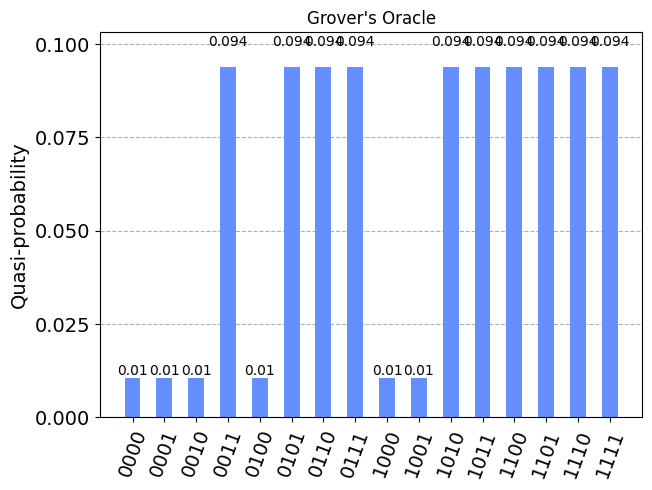

In [36]:
graph_problem = GraphProblem("/Users/mac/workspace/quantum-journey/QUANTUM-CLASSICAL-TRANSLATION/classical_to_quantum/cases/Gset/G0")
independent_set_cnf = independent_set_to_sat(graph_problem.graph())
independent_set_oracle = cnf_to_quantum_oracle_optimized(independent_set_cnf)
def fun(state):
    return True
grover = GroverWrapper(oracle=independent_set_oracle,
                       iterations=8,
                       is_good_state=fun,
                       objective_qubits=list(range(graph_problem.num_nodes)))
is_res = grover.run(verbose=True)
display(plot_histogram(is_res.circuit_results[0], title="Grover's Oracle"))

# TOP solutions are all correct!!!

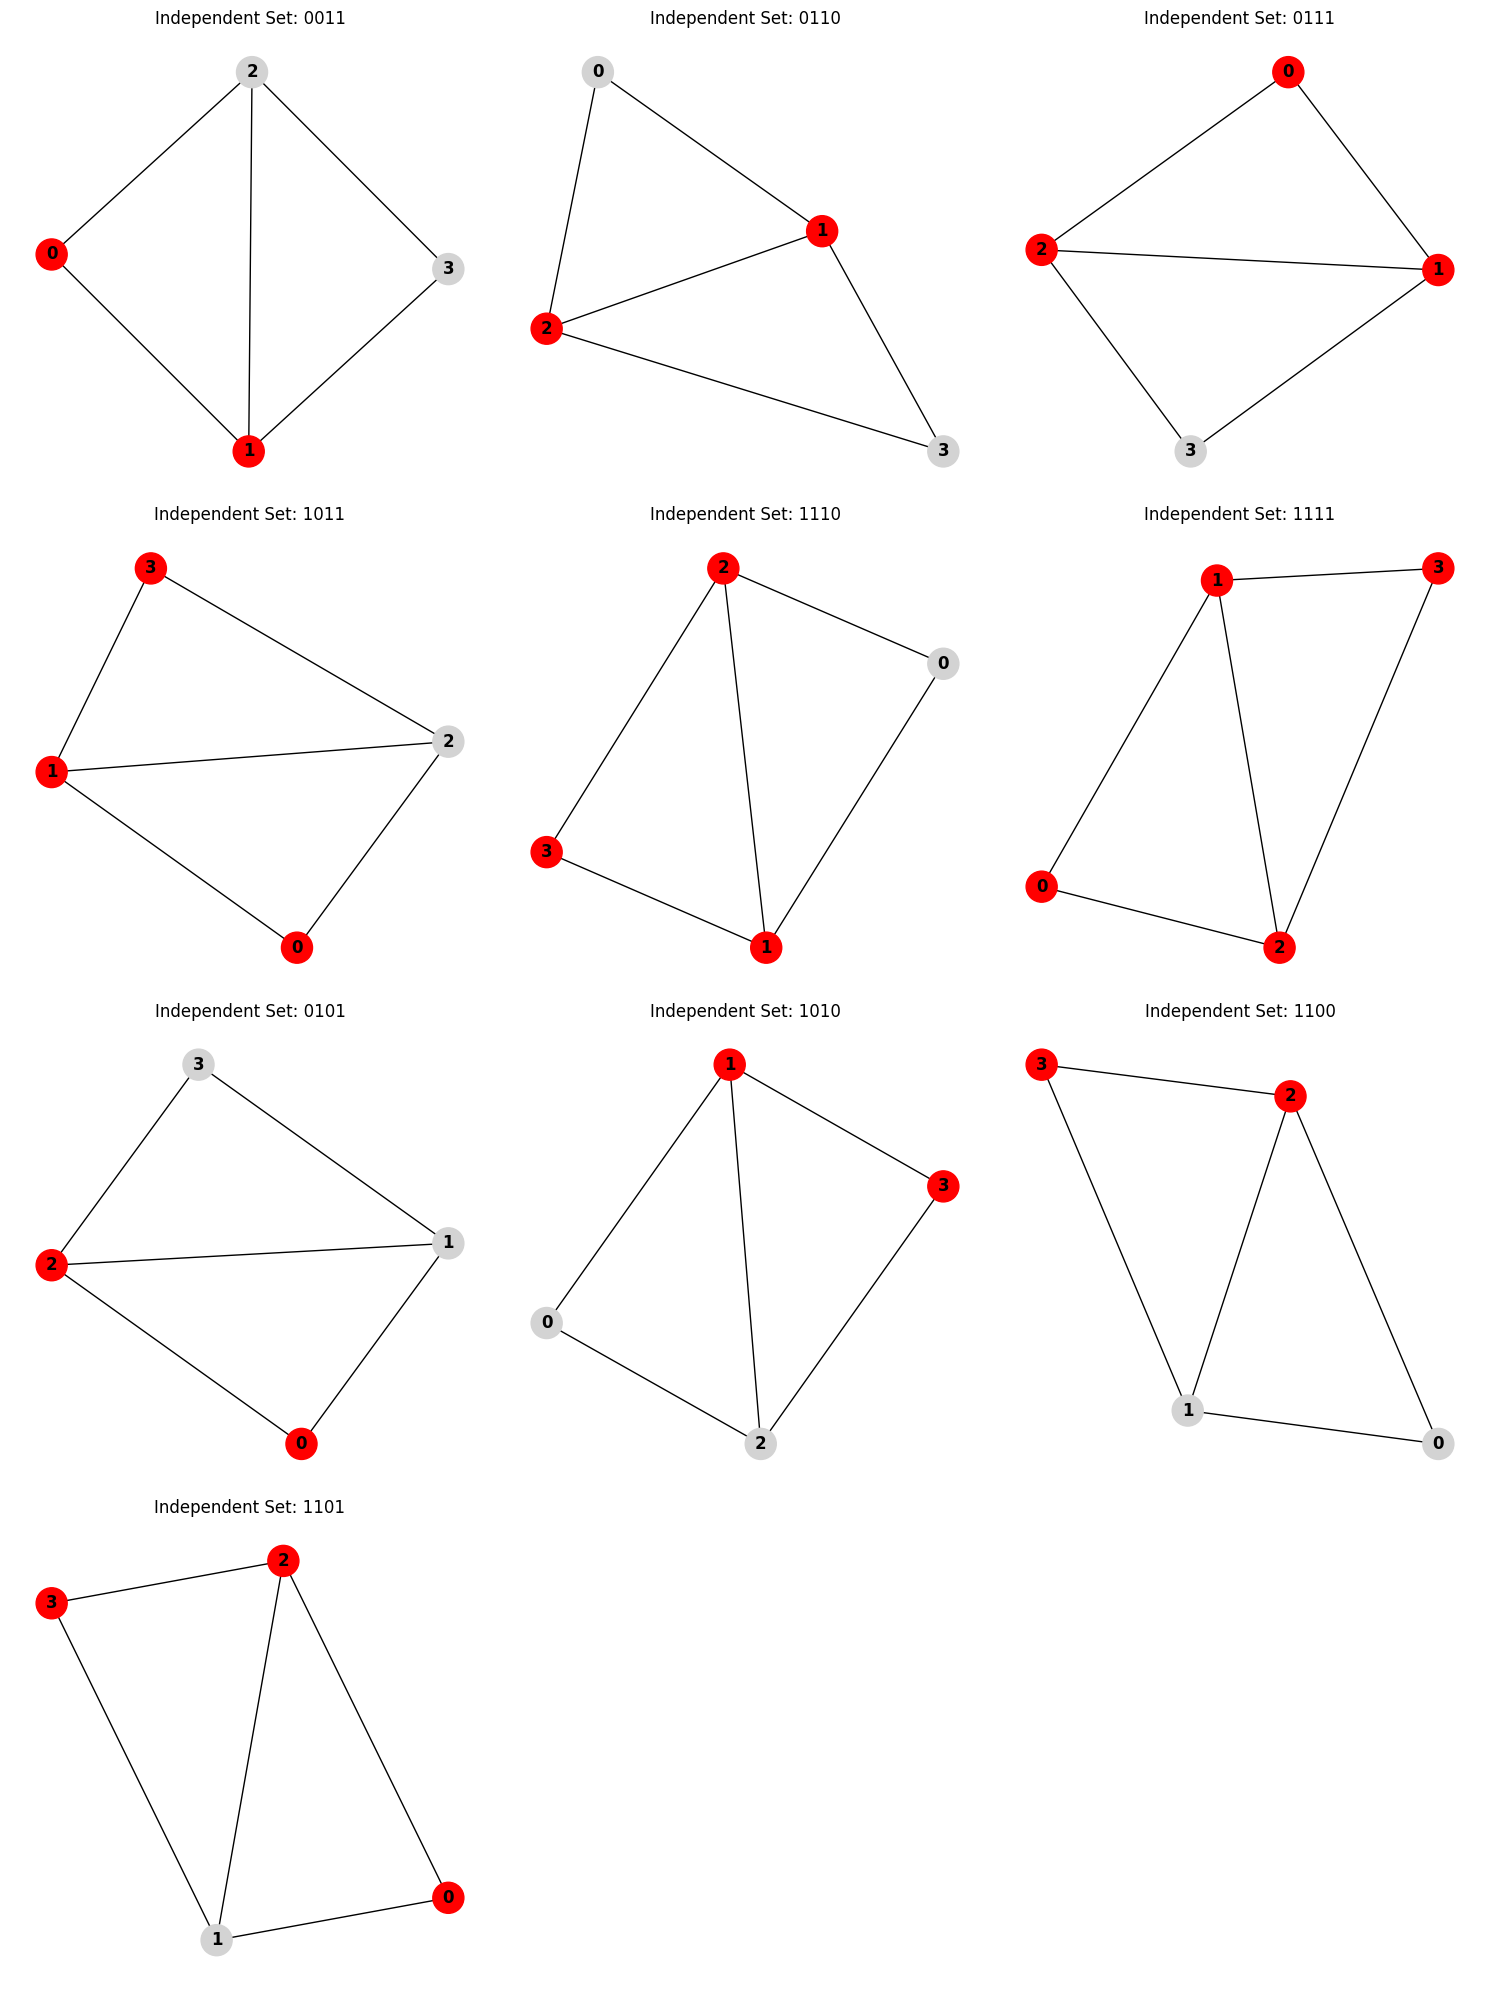

In [22]:
top_is_measurements = get_top_measurements(is_res, num=100)
plot_multiple_independent_sets(graph_problem.graph(), top_is_measurements)

# Example: graph 4-coloring
	1.	Coloring Problems to SAT: Coloring problems are first reduced to a Satisfiability Problem (SAT). A quantum oracle is then constructed, and Grover’s algorithm is applied.
	•	In the 4-coloring problem, each color is represented by two bits (e.g., 00 for red, 10 for green).
	2.	Quantum Approximate Optimization Algorithm (QAOA): A correlated cost Hamiltonian is constructed based on specific problem conditions, which is then optimized using QAOA.

In [9]:
coloring_problem = GraphColor("/Users/mac/workspace/quantum-journey/QUANTUM-CLASSICAL-TRANSLATION/classical_to_quantum/cases/Gset/G0", verbose=True)
coloring_grover_res = coloring_problem.run(verbose=True)

Variable Qubits: [0, 1, 2, 3, 4, 5, 6, 7]
Check Qubits: [8, 9, 10, 11, 12]
Disagree List: [[[0, 1], [2, 3]], [[0, 1], [4, 5]], [[2, 3], [4, 5]], [[2, 3], [6, 7]], [[4, 5], [6, 7]]]
Output Qubit: 13
{   'assignment': '00011000',
    'circuit_results': [   {   '00000000': 0.0020751953125,
                               '00000001': 0.0020751953125,
                               '00000010': 0.0020751953125,
                               '00000011': 0.0020751953125,
                               '00000100': 0.0020751953125,
                               '00000101': 0.0020751953125,
                               '00000110': 0.0020751953125,
                               '00000111': 0.0020751953125,
                               '00001000': 0.0020751953125,
                               '00001001': 0.0020751953125,
                               '00001010': 0.0020751953125,
                               '00001011': 0.0020751953125,
                               '00001100': 0.0020751

### Retrieve the top measurements that are most likely to represent solutions.

In [70]:
bitstring_results = get_top_measurements(coloring_grover_res)
bitstring_results    

[{'00011000': 0.0118408203125005},
 {'00011011': 0.0118408203125005},
 {'00100111': 0.0118408203125005}]

### Interpret the results from the quantum circuit for graph-related problems.

Plotting for bitstring 00011000 with color assignment: {0: 'red', 1: 'green', 2: 'blue', 3: 'red'}
Plotting for bitstring 00011011 with color assignment: {0: 'red', 1: 'green', 2: 'blue', 3: 'yellow'}
Plotting for bitstring 00100111 with color assignment: {0: 'red', 1: 'blue', 2: 'green', 3: 'yellow'}


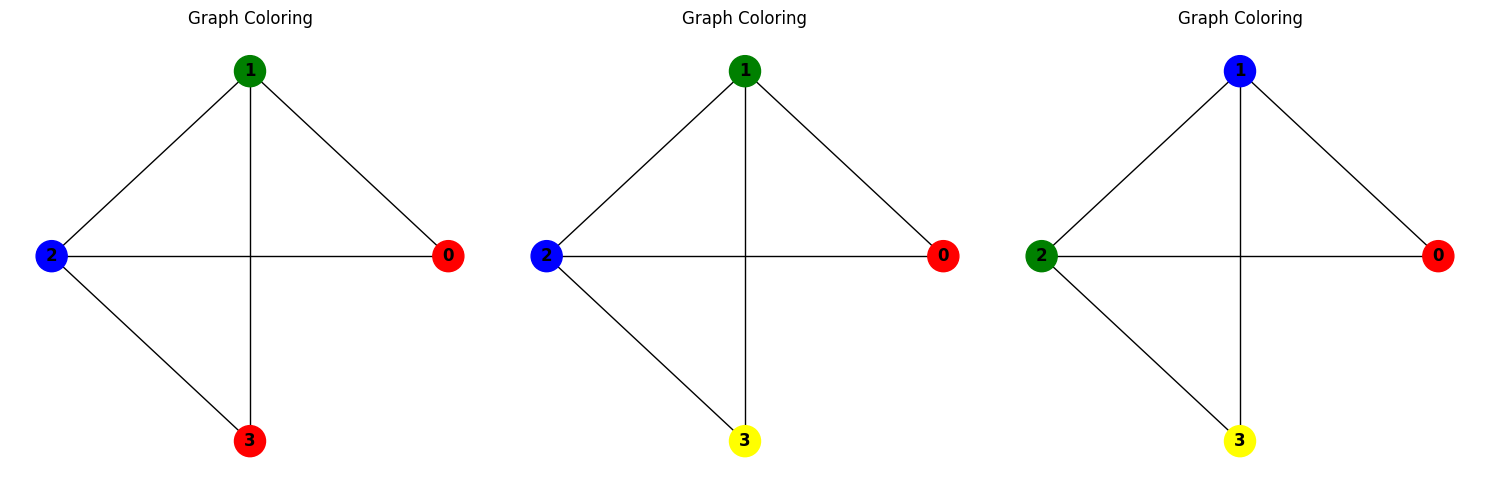

In [71]:
plot_multiple_graph_colorings(coloring_problem.graph(), bitstring_results, num_per_row=3)

### QAOA counterpart for 4_coloring problems 

-- cannot find parameters matching version: , using: 22.1.1.0


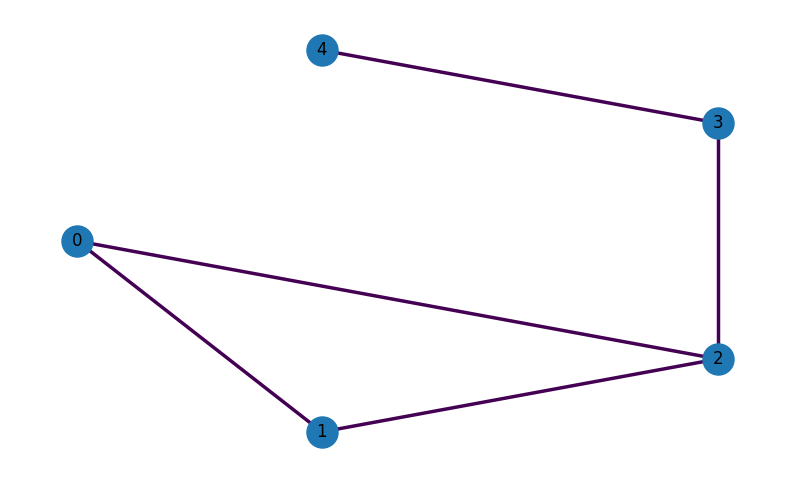

In [72]:
coloring_problem_ising = Ising(
            "/Users/mac/workspace/quantum-journey/QUANTUM-CLASSICAL-TRANSLATION/classical_to_quantum/cases/Gset/G3",
            "KColor")
coloring_problem_ising.plot_graph()
result = coloring_problem_ising.run(verbose=False)

Skipping invalid solution 1: 'c' argument has 9 elements, which is inconsistent with 'x' and 'y' with size 5.
Skipping invalid solution 2: 'c' argument has 7 elements, which is inconsistent with 'x' and 'y' with size 5.
Skipping invalid solution 4: 'c' argument has 7 elements, which is inconsistent with 'x' and 'y' with size 5.
Skipping invalid solution 5: 'c' argument has 7 elements, which is inconsistent with 'x' and 'y' with size 5.
Skipping invalid solution 7: 'c' argument has 6 elements, which is inconsistent with 'x' and 'y' with size 5.
Skipping invalid solution 8: 'c' argument has 7 elements, which is inconsistent with 'x' and 'y' with size 5.


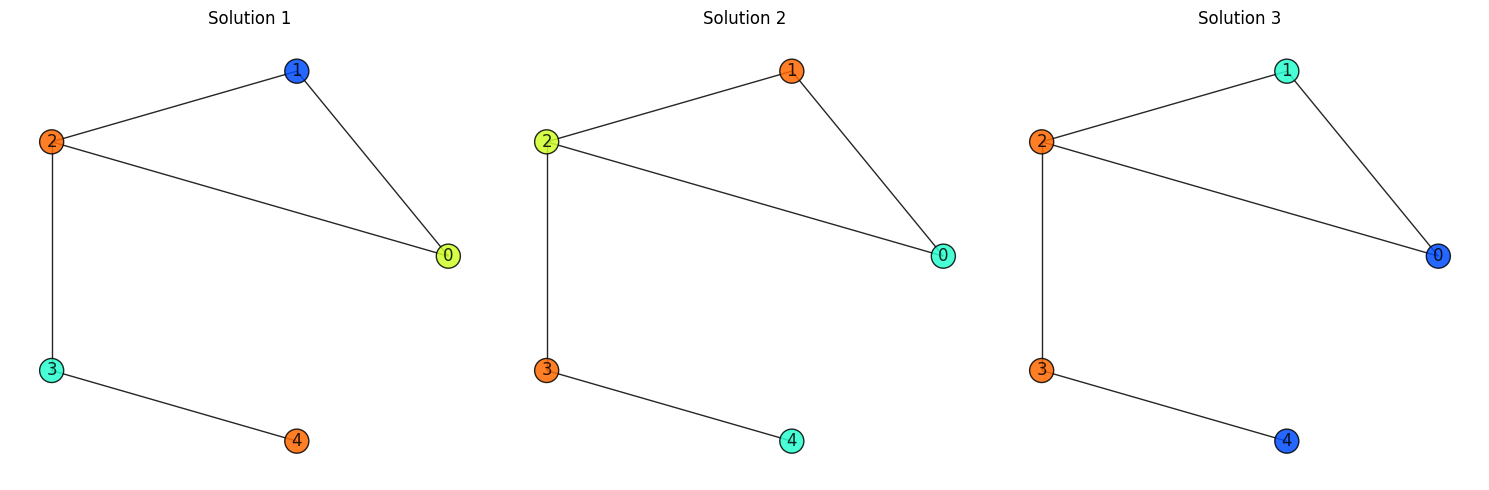

In [57]:
solutions = result.most_probable_states.get('solutions_bitstrings')
plot_first_valid_coloring_solutions(solutions, coloring_problem_ising)


# Classical bruteforce solutions for independent set and its recommended quantum solutions: quantum oracle and QAOA are given

problem type: ProblemType.GRAPH data: Graph with 5 nodes and 5 edges
-------graph problem type:MIS--------
<class 'classical_to_quantum.applications.graph.Ising.Ising'>
-- cannot find parameters matching version: , using: 22.1.1.0
{'angles': [0.584652534436, 0.35210653055, 0.11899483725, 0.119186527067, 0.349748055969, 0.585024721328], 'cost': -1.87, 'measurement_outcomes': {'01100': 1, '10101': 1, '00001': 2, '10011': 2, '10010': 9, '01001': 4, '00110': 14, '00100': 3, '10000': 6, '10100': 12, '00000': 1, '01000': 7, '00101': 2, '10110': 18, '00010': 2, '10001': 16}, 'job_id': '85e41dc8-f4a3-4541-b552-b5f1ecf314cf', 'eval_number': 132}


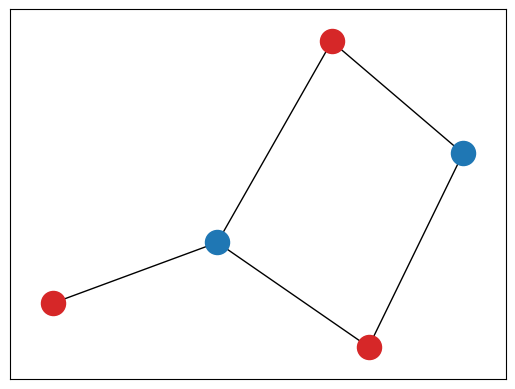

<class 'classical_to_quantum.applications.graph.graph_problem.GraphProblem'>
{   'assignment': '00010',
    'circuit_results': [   {   '00000': 0.0703124999999972,
                               '00001': 0.0703124999999972,
                               '00010': 0.0703124999999974,
                               '00011': 0.0078124999999997,
                               '00100': 0.0703124999999974,
                               '00101': 0.0703124999999974,
                               '00110': 0.0078124999999997,
                               '00111': 0.0078124999999997,
                               '01000': 0.0703124999999972,
                               '01001': 0.0703124999999972,
                               '01010': 0.0078124999999998,
                               '01011': 0.0078124999999997,
                               '01100': 0.0703124999999974,
                               '01101': 0.0703124999999974,
                               '01110': 0.00781249999999

In [62]:
qasm_code = generator.qasm_generate(classical_code=independent_set_code, verbose=True)
grover_code = qasm_code.get('grover')
qaoa_code = qasm_code.get('qaoa')

## Generated QASM code

In [56]:
grover_circuit = qasm2.loads(grover_code, custom_instructions=qasm2.LEGACY_CUSTOM_INSTRUCTIONS)
qaoa_circuit = qasm2.loads(qaoa_code, custom_instructions=qasm2.LEGACY_CUSTOM_INSTRUCTIONS)
print(qaoa_circuit)
print(grover_circuit)

        ┌───┐               ┌───────┐  ┌─────────────┐              »
 q11_0: ┤ H ├─■─────────────┤ Rz(0) ├──┤ Rx(-1.1925) ├──────────────»
        ├───┤ │ZZ(0.1115)   └───────┘  └─────────────┘┌────────────┐»
 q11_1: ┤ H ├─■────────────■─────────────■────────────┤ Rz(-0.223) ├»
        ├───┤              │ZZ(0.1115)   │            └────────────┘»
 q11_2: ┤ H ├──────────────■─────────────┼─────────────■────────────»
        ├───┤                            │ZZ(0.1115)   │            »
 q11_3: ┤ H ├────────────────────────────■─────────────┼────────────»
        ├───┤                                          │ZZ(0.1115)  »
 q11_4: ┤ H ├──────────────────────────────────────────■────────────»
        └───┘                                                       »
meas: 5/════════════════════════════════════════════════════════════»
                                                                    »
«                                         ┌───────┐   ┌──────────────┐»
« q11_0: ─────────

In [63]:
grover_circuit = qasm2.loads(grover_code, custom_instructions=qasm2.LEGACY_CUSTOM_INSTRUCTIONS)
qaoa_circuit = qasm2.loads(qaoa_code, custom_instructions=qasm2.LEGACY_CUSTOM_INSTRUCTIONS)
print(qaoa_circuit)
print(grover_circuit)

        ┌───┐                ┌───────┐   ┌─────────────┐                »
 q14_0: ┤ H ├─■──────────────┤ Rz(0) ├───┤ Rx(-1.1693) ├────────────────»
        ├───┤ │ZZ(0.11919)   └───────┘   └─────────────┘┌──────────────┐»
 q14_1: ┤ H ├─■─────────────■──────────────■────────────┤ Rz(-0.23837) ├»
        ├───┤               │ZZ(0.11919)   │            └──────────────┘»
 q14_2: ┤ H ├───────────────■──────────────┼──────────────■─────────────»
        ├───┤                              │ZZ(0.11919)   │             »
 q14_3: ┤ H ├──────────────────────────────■──────────────┼─────────────»
        ├───┤                                             │ZZ(0.11919)  »
 q14_4: ┤ H ├─────────────────────────────────────────────■─────────────»
        └───┘                                                           »
meas: 5/════════════════════════════════════════════════════════════════»
                                                                        »
«                                     

# An example for coloring problem, where generator recommends grover algorithm and QAOA

problem type: ProblemType.GRAPH data: Graph with 5 nodes and 5 edges
-------graph problem type:KColor--------
<class 'classical_to_quantum.applications.graph.Ising.Ising'>
{'angles': [0.61675153255, 0.359419972508, 0.12251366554, 0.111505963289, 0.348747016668, 0.568025873603], 'cost': 180.92, 'measurement_outcomes': {'10000100000110000010': 1, '00000010100000001000': 1, '00101000000110000000': 1, '00010011000110010100': 1, '11000100110010100100': 1, '00100110011000001000': 1, '01000000000110000100': 1, '00100000010000000001': 1, '10001010100001000000': 1, '00100100000000001000': 1, '01000100010110000100': 1, '00101000000001001110': 1, '00110000010100010001': 1, '00000101001010000010': 1, '00111000000001000010': 1, '11110010101100000010': 1, '00001011101010010110': 1, '00100000100100000001': 1, '00010100100000010010': 1, '10000001000001000100': 1, '00100000100001000001': 1, '00000111110000100010': 1, '00010011010100010001': 1, '01100001000001011000': 1, '01001000000000111000': 1, '0001

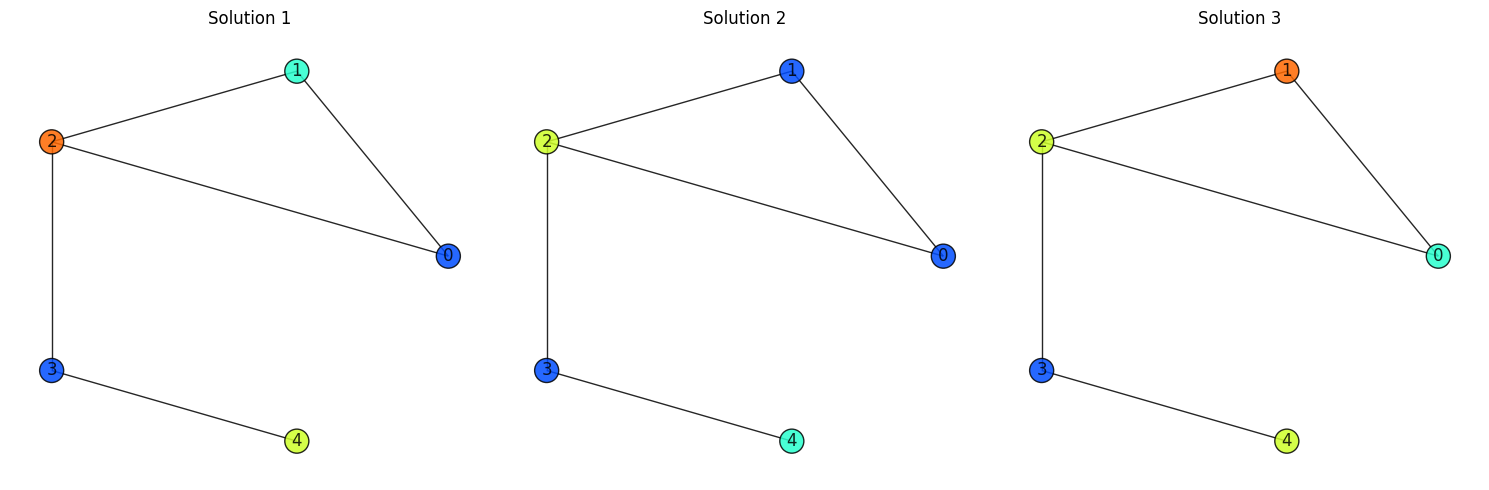

<class 'classical_to_quantum.applications.graph.grover_applications.graph_color.GraphColor'>
{   'assignment': '0001000110',
    'circuit_results': [   {   '0000000000': 0.0016925632953658,
                               '0000000001': 0.0005100071430206,
                               '0000000010': 0.0005100071430206,
                               '0000000011': 0.0005100071430206,
                               '0000000100': 0.0016925632953657,
                               '0000000101': 0.0016925632953656,
                               '0000000110': 0.0005100071430207,
                               '0000000111': 0.0005100071430207,
                               '0000001000': 0.0016925632953657,
                               '0000001001': 0.0005100071430206,
                               '0000001010': 0.0016925632953656,
                               '0000001011': 0.0005100071430206,
                               '0000001100': 0.0016925632953657,
                              

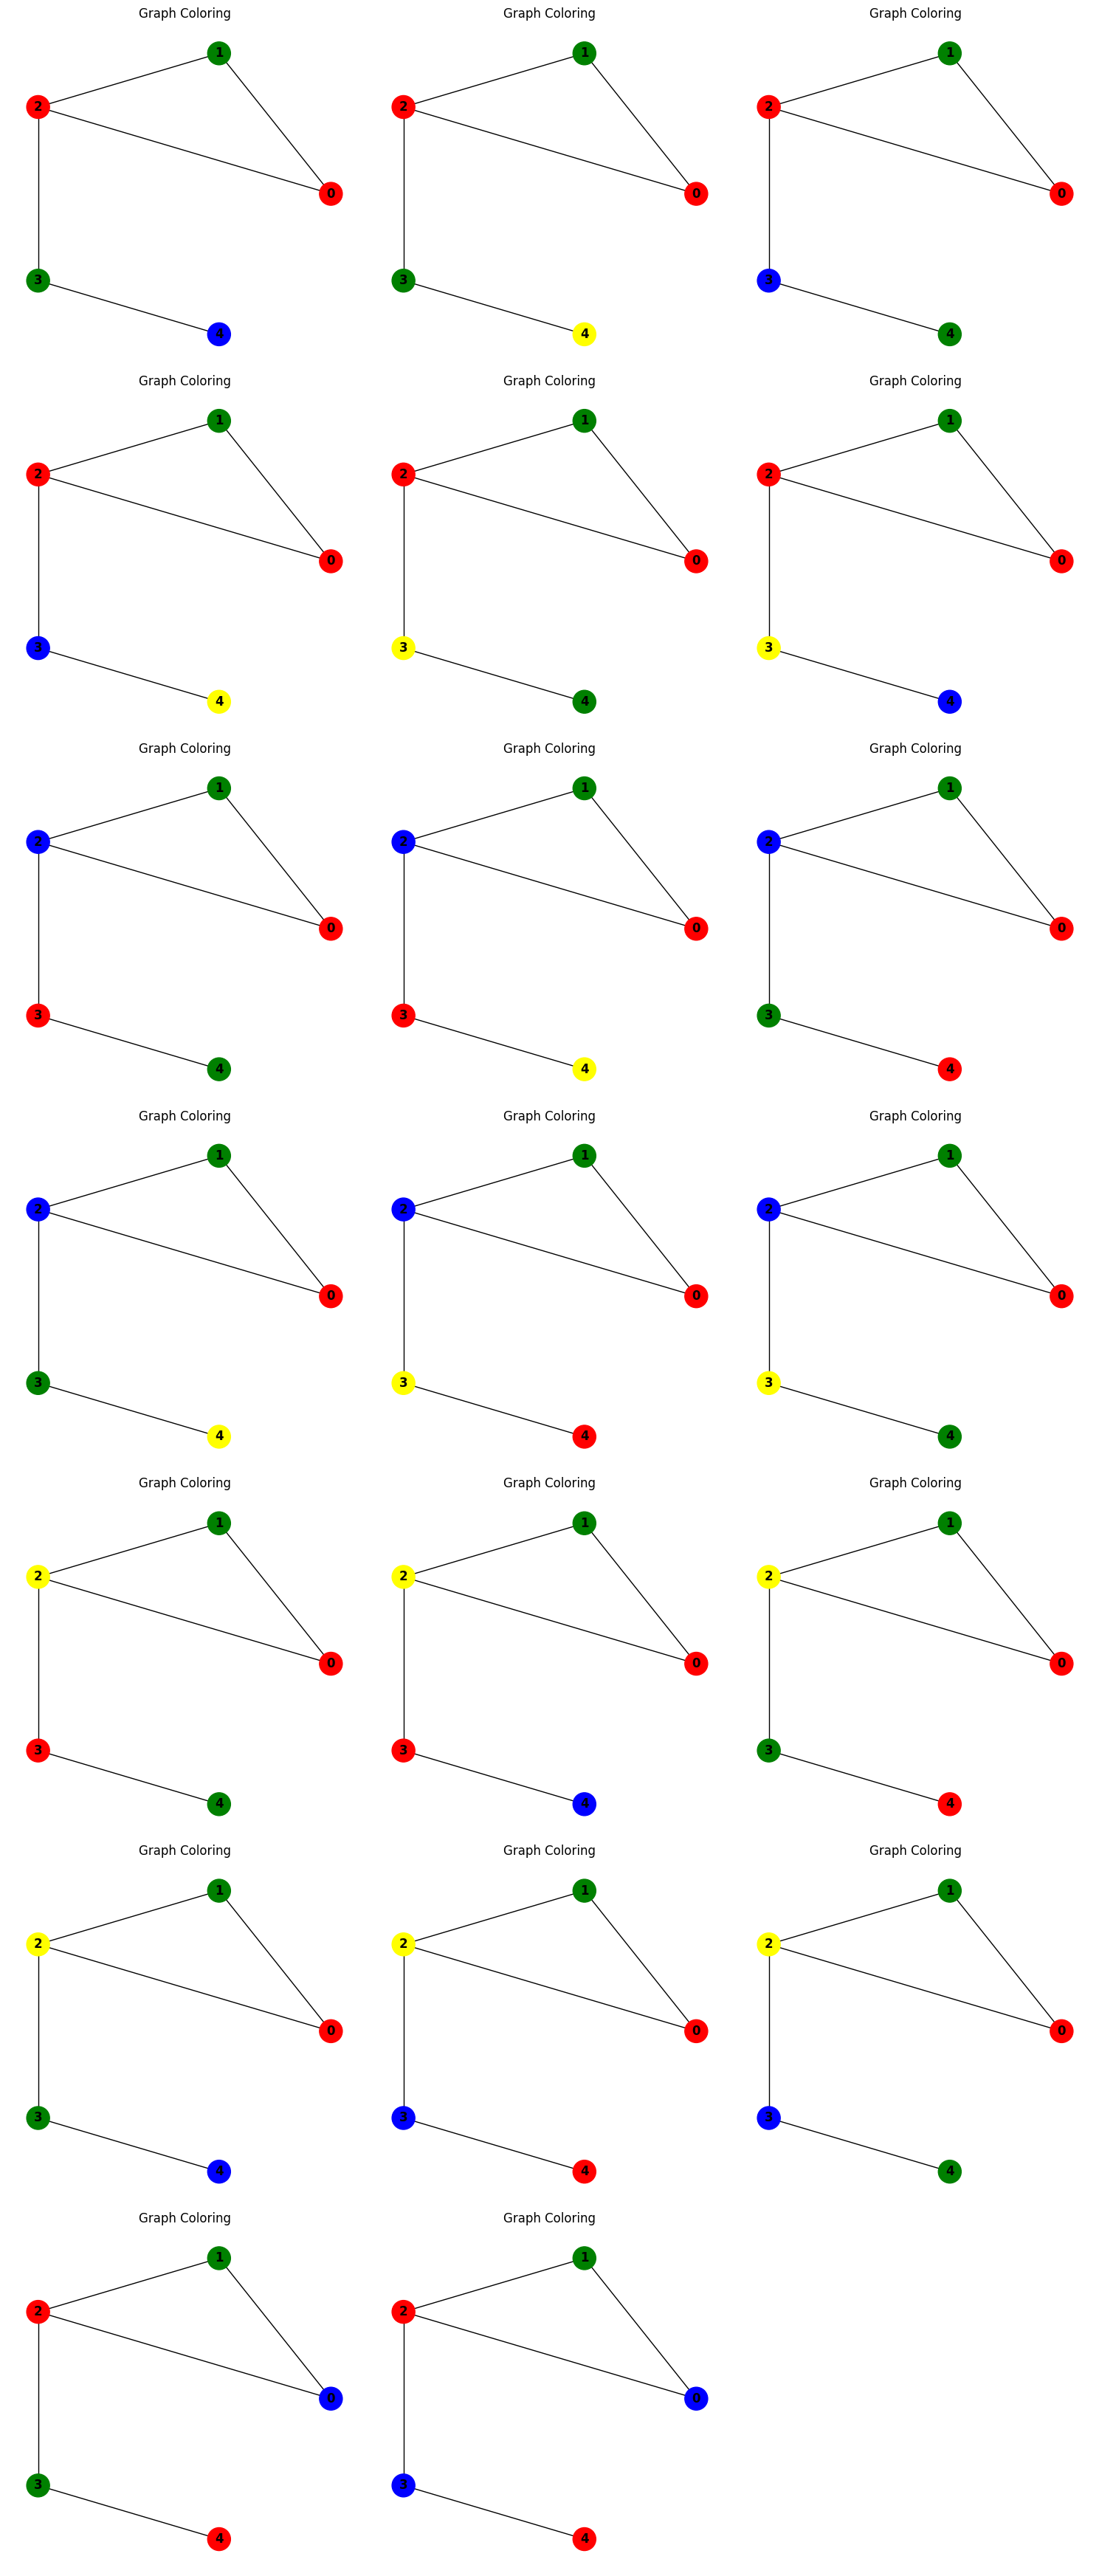

         ┌───┐                                                        »
   q1_0: ┤ H ├─■──────────────────────────────────────────────────────»
         ├───┤ │                                                      »
   q1_1: ┤ H ├─┼─────────────■────────────────────────────────────────»
         ├───┤ │             │                                        »
   q1_2: ┤ H ├─┼─────────────┼─────────────■──────────────────────────»
         ├───┤ │             │             │                          »
   q1_3: ┤ H ├─┼─────────────┼─────────────┼─────────────■────────────»
         ├───┤ │ZZ(0.22301)  │             │             │            »
   q1_4: ┤ H ├─■─────────────┼─────────────┼─────────────┼────────────»
         ├───┤               │ZZ(0.22301)  │             │            »
   q1_5: ┤ H ├───────────────■─────────────┼─────────────┼────────────»
         ├───┤                             │ZZ(0.22301)  │            »
   q1_6: ┤ H ├─────────────────────────────■─────────────┼──────

In [3]:
qasm_code = generator.qasm_generate(classical_code=coloring_code, verbose=True)
grover_code = qasm_code.get('grover')
qaoa_code = qasm_code.get('qaoa')
grover_circuit = qasm2.loads(grover_code, custom_instructions=qasm2.LEGACY_CUSTOM_INSTRUCTIONS)
qaoa_circuit = qasm2.loads(qaoa_code, custom_instructions=qasm2.LEGACY_CUSTOM_INSTRUCTIONS)
print(qaoa_circuit)
print(grover_circuit)

### An example to find triangle in graph

problem type: ProblemType.GRAPH data: Graph with 5 nodes and 7 edges
-------graph problem type:Triangle--------
<class 'classical_to_quantum.applications.graph.grover_applications.triangle_finding.TriangleFinding'>
[(0, 1), (0, 2), (0, 3), (1, 2), (1, 4), (2, 3), (3, 4)]
[(0, 1), (0, 2), (0, 3), (1, 2), (1, 4), (2, 3), (3, 4)]
---doing 4 iterations---
{   'assignment': '01101',
    'circuit_results': [   {   '00000': 0.030627520754929,
                               '00001': 0.0306275207549293,
                               '00010': 0.030627520754929,
                               '00011': 0.0306275207549292,
                               '00100': 0.030627520754929,
                               '00101': 0.0306275207549285,
                               '00110': 0.030627520754929,
                               '00111': 0.0372672993689719,
                               '01000': 0.030627520754929,
                               '01001': 0.0306275207549293,
                        

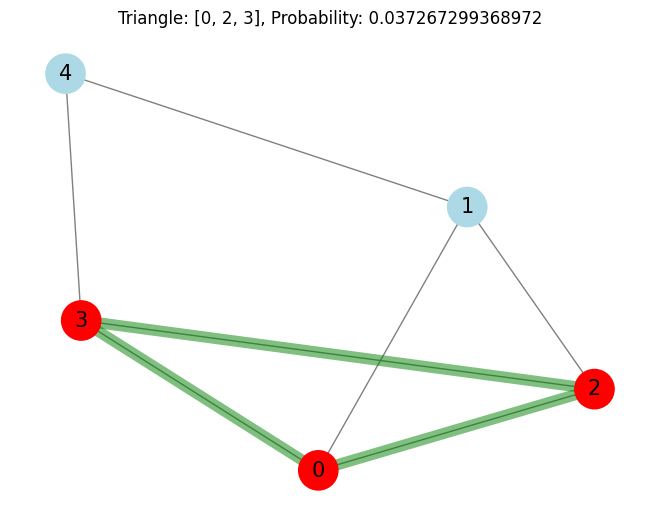

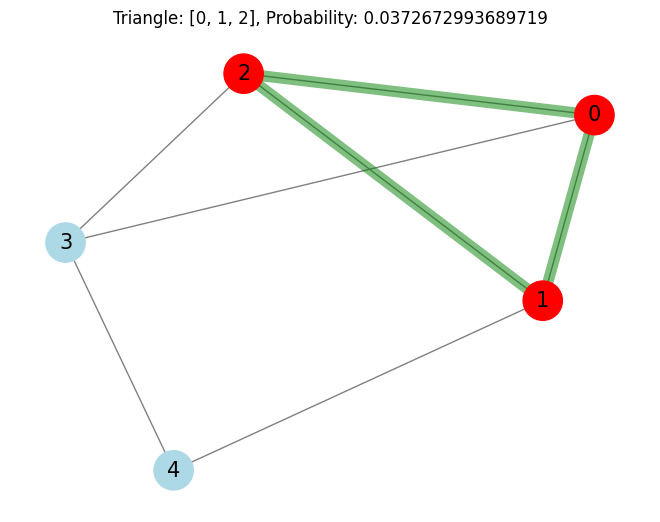

{'grover': 'OPENQASM 2.0;\ninclude "qelib1.inc";\ngate mcx q0,q1,q2,q3 { h q3; p(pi/8) q0; p(pi/8) q1; p(pi/8) q2; p(pi/8) q3; cx q0,q1; p(-pi/8) q1; cx q0,q1; cx q1,q2; p(-pi/8) q2; cx q0,q2; p(pi/8) q2; cx q1,q2; p(-pi/8) q2; cx q0,q2; cx q2,q3; p(-pi/8) q3; cx q1,q3; p(pi/8) q3; cx q2,q3; p(-pi/8) q3; cx q0,q3; p(pi/8) q3; cx q2,q3; p(-pi/8) q3; cx q1,q3; p(pi/8) q3; cx q2,q3; p(-pi/8) q3; cx q0,q3; h q3; }\ngate mcu1(param0) q0,q1,q2,q3,q4,q5,q6,q7,q8,q9,q10 { cu1(pi/512) q9,q10; cx q9,q8; cu1(-pi/512) q8,q10; cx q9,q8; cu1(pi/512) q8,q10; cx q8,q7; cu1(-pi/512) q7,q10; cx q9,q7; cu1(pi/512) q7,q10; cx q8,q7; cu1(-pi/512) q7,q10; cx q9,q7; cu1(pi/512) q7,q10; cx q7,q6; cu1(-pi/512) q6,q10; cx q9,q6; cu1(pi/512) q6,q10; cx q8,q6; cu1(-pi/512) q6,q10; cx q9,q6; cu1(pi/512) q6,q10; cx q7,q6; cu1(-pi/512) q6,q10; cx q9,q6; cu1(pi/512) q6,q10; cx q8,q6; cu1(-pi/512) q6,q10; cx q9,q6; cu1(pi/512) q6,q10; cx q6,q5; cu1(-pi/512) q5,q10; cx q9,q5; cu1(pi/512) q5,q10; cx q8,q5; cu1(-pi/512) 

In [4]:
generator.qasm_generate(triangle_finding_code, verbose=True)

# Vehicle routing problem
- a case with 5 codes and 2 vehicles (represented by two colors)

problem type: ProblemType.GRAPH data: Graph with 5 nodes and 10 edges
-------graph problem type:VRP--------
<class 'classical_to_quantum.applications.graph.Ising.Ising'>
[(0, 1), (0, 2), (0, 3), (0, 4), (1, 2), (1, 3), (1, 4), (2, 3), (2, 4), (3, 4)]
{'angles': [0.578363766448, 0.348846960162, 0.119190749265, 0.12003484033, 0.359742123326, 0.566509948156], 'cost': 166.71, 'measurement_outcomes': {'1000010001': 1, '0110011001': 1, '1000010000': 1, '1110111001': 1, '0011111001': 1, '0000010110': 1, '1001011010': 1, '1110111011': 1, '0000001000': 1, '1011010011': 1, '1001001010': 1, '1101101110': 1, '0100111011': 1, '0110010111': 1, '0001101111': 1, '1010111000': 1, '1011011111': 1, '1001110101': 2, '1010010000': 1, '1010000000': 1, '1111001000': 1, '1001010111': 1, '1100011000': 1, '1001000000': 2, '0100111100': 1, '1100000000': 1, '1110010100': 1, '0000011000': 1, '1001101010': 1, '1100100010': 1, '1100011010': 1, '1011000110': 1, '1000110011': 1, '1111110000': 1, '1101111111': 1, '1100

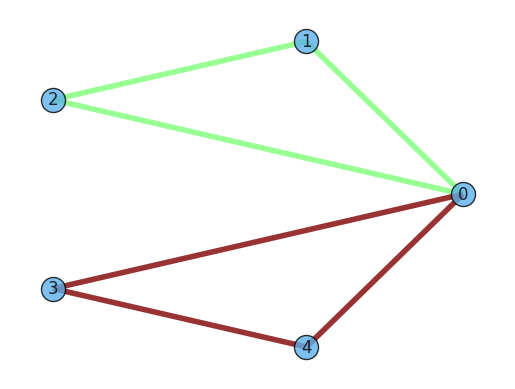

         ┌───┐                                                        »
   q3_0: ┤ H ├─■─────────────■─────────────■──────────────────────────»
         ├───┤ │ZZ(0.48014)  │             │                          »
   q3_1: ┤ H ├─■─────────────┼─────────────┼─────────────■────────────»
         ├───┤               │ZZ(0.48014)  │             │ZZ(0.48014) »
   q3_2: ┤ H ├───────────────■─────────────┼─────────────■────────────»
         ├───┤                             │ZZ(0.48014)               »
   q3_3: ┤ H ├─────────────────────────────■──────────────────────────»
         ├───┤                                                        »
   q3_4: ┤ H ├────────────────────────────────────────────────────────»
         ├───┤                                                        »
   q3_5: ┤ H ├────────────────────────────────────────────────────────»
         ├───┤                                                        »
   q3_6: ┤ H ├──────────────────────────────────────────────────

In [5]:
vrp_qasm = generator.qasm_generate(vrp_code, verbose=True)
print(qasm2.loads(vrp_qasm.get('qaoa'), custom_instructions=qasm2.LEGACY_CUSTOM_INSTRUCTIONS))

## Quantum Multiplication 

In [5]:
multiplication_qasm = generator.qasm_generate(multiplication_code, verbose=True)
print(qasm2.loads(multiplication_qasm.get('QFT'), custom_instructions=qasm2.LEGACY_CUSTOM_INSTRUCTIONS))

problem type: ProblemType.ARITHMETICS data: {'left': 4, 'right': 5}
quantum Multiplication result: 20
           ┌────────────────────────┐                  
 q_0: ─────┤0                       ├──────────────────
           │                        │                  
 q_1: ─────┤1                       ├──────────────────
      ┌───┐│                        │                  
 q_2: ┤ X ├┤2                       ├──────────────────
      ├───┤│                        │                  
 q_3: ┤ X ├┤3                       ├──────────────────
      └───┘│                        │                  
 q_4: ─────┤4                       ├──────────────────
      ┌───┐│                        │                  
 q_5: ┤ X ├┤5                       ├──────────────────
      └───┘│   Gate_rgqftmultiplier │┌─┐               
 q_6: ─────┤6                       ├┤M├───────────────
           │                        │└╥┘┌─┐            
 q_7: ─────┤7                       ├─╫─┤M├────────────
  

# Quantum conjunctive normal formula

In [107]:
cnf_qasm = generator.qasm_generate(cnf_code, verbose=True)
print(qasm2.loads(cnf_qasm.get('grover'), custom_instructions=qasm2.LEGACY_CUSTOM_INSTRUCTIONS))

problem type: ProblemType.CNF data: [[-1, -2, -3], [1, -2, 3], [1, 2, -3], [1, -2, -3], [-1, 2, 3]]
{   'assignment': '000',
    'circuit_results': [   {   '000': 0.2812499999999996,
                               '001': 0.0312499999999999,
                               '010': 0.0312499999999999,
                               '011': 0.2812499999999995,
                               '100': 0.03125,
                               '101': 0.2812499999999995,
                               '110': 0.0312499999999999,
                               '111': 0.03125}],
    'iterations': [1],
    'max_probability': 0.2812499999999996,
    'oracle_evaluation': True,
    'top_measurement': '000'}
     ┌───┐┌────────────────────┐┌─────────────────────┐┌─┐      
q_0: ┤ H ├┤0                   ├┤0                    ├┤M├──────
     ├───┤│                    ││                     │└╥┘┌─┐   
q_1: ┤ H ├┤1 Gate_q_6248185088 ├┤1 Gate_q_11529635968 ├─╫─┤M├───
     ├───┤│                    ││           

## Quantum factorization (Grover and Shor algorithms)

In [7]:
factor_qasm = generator.qasm_generate(factor_code, verbose=True)
factor_grover_qasm = factor_qasm.get('grover')
factor_circuit = qasm2.loads(factor_grover_qasm, custom_instructions=qasm2.LEGACY_CUSTOM_INSTRUCTIONS)
print(factor_circuit)

problem type: ProblemType.FACTOR data: {'composite number': 35}
[{'101': 0.1689453124999865}, {'111': 0.1689453124999864}]
      ┌───┐┌──────────────────────┐┌─┐      
 q_0: ┤ H ├┤0                     ├┤M├──────
      ├───┤│                      │└╥┘┌─┐   
 q_1: ┤ H ├┤1                     ├─╫─┤M├───
      ├───┤│                      │ ║ └╥┘┌─┐
 q_2: ┤ H ├┤2                     ├─╫──╫─┤M├
      ├───┤│                      │ ║  ║ └╥┘
 q_3: ┤ H ├┤3                     ├─╫──╫──╫─
      ├───┤│                      │ ║  ║  ║ 
 q_4: ┤ H ├┤4                     ├─╫──╫──╫─
      ├───┤│                      │ ║  ║  ║ 
 q_5: ┤ H ├┤5                     ├─╫──╫──╫─
      └───┘│                      │ ║  ║  ║ 
 q_6: ─────┤6  Gate_q_11275946400 ├─╫──╫──╫─
           │                      │ ║  ║  ║ 
 q_7: ─────┤7                     ├─╫──╫──╫─
           │                      │ ║  ║  ║ 
 q_8: ─────┤8                     ├─╫──╫──╫─
           │                      │ ║  ║  ║ 
 q_9: ─────┤9         

### Retrieve generated qasm code, run on local simulators and interpret results...
- 5 and 7 with probability of $19.5\%$, which is correct answer $5*7=35$

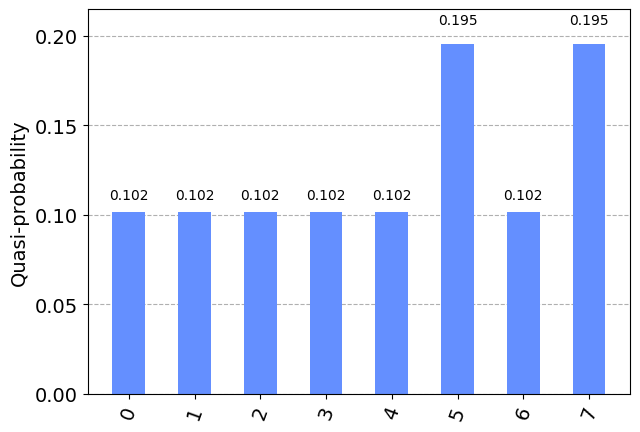

In [8]:
res = generator.run_qasm_simulator(factor_qasm.get('grover'))
plot_histogram(res.quasi_dists)

In [2]:
classical_code = """
def is_independent_set(graph, subset):
    # Check if the subset is an independent set
    for i in range(len(subset)):
        for j in range(i + 1, len(subset)):
            if graph[subset[i]][subset[j]] == 1:
                return False
    return True

def find_max_independent_set(graph):
    n = len(graph)
    nodes = list(range(n))
    max_independent_set = []

    # Check all possible subsets
    for size in range(1, n + 1):
        for subset in itertools.combinations(nodes, size):
            if is_independent_set(graph, subset):
                if len(subset) > len(max_independent_set):
                    max_independent_set = subset

    return max_independent_set

# Example usage:
# Adjacency matrix representation of the graph
graph = [
    [0, 1, 0, 0, 0],
    [1, 0, 1, 1, 0],
    [0, 1, 0, 0, 1],
    [0, 1, 0, 0, 1],
    [0, 0, 1, 1, 0]
]

max_independent_set = find_max_independent_set(graph)
print("Maximum Independent Set:", max_independent_set)
"""
from classical_to_quantum.Framework.recommender import *

problem type: ProblemType.GRAPH data: Graph with 5 nodes and 5 edges
-------graph problem type:MIS--------
<class 'classical_to_quantum.applications.graph.Ising.Ising'>
{'angles': [0.593055555555, 0.3325, 0.118611111111, 0.118611111111, 0.355833333333, 0.593055555555], 'cost': -1.81, 'measurement_outcomes': {'11100': 1, '00101': 1, '10010': 6, '01010': 1, '00110': 13, '10001': 19, '00010': 4, '10000': 3, '10101': 2, '01000': 8, '00000': 4, '00001': 4, '10100': 8, '01001': 7, '11001': 1, '10110': 18}, 'job_id': 'd1d95f19-6d1c-46eb-99a5-e0c5a9743956', 'eval_number': 8}


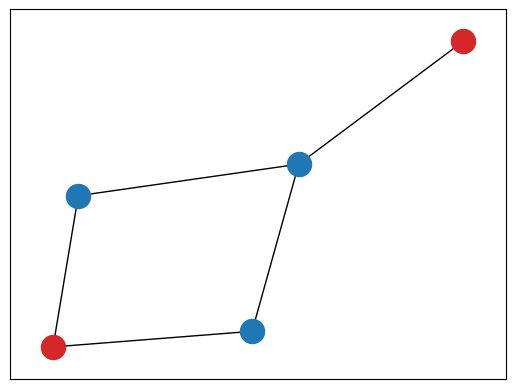

<class 'classical_to_quantum.applications.graph.graph_problem.GraphProblem'>
{   'assignment': '00010',
    'circuit_results': [   {   '00000': 0.0703124999999972,
                               '00001': 0.0703124999999972,
                               '00010': 0.0703124999999974,
                               '00011': 0.0078124999999997,
                               '00100': 0.0703124999999974,
                               '00101': 0.0703124999999974,
                               '00110': 0.0078124999999997,
                               '00111': 0.0078124999999997,
                               '01000': 0.0703124999999972,
                               '01001': 0.0703124999999972,
                               '01010': 0.0078124999999998,
                               '01011': 0.0078124999999997,
                               '01100': 0.0703124999999974,
                               '01101': 0.0703124999999974,
                               '01110': 0.00781249999999

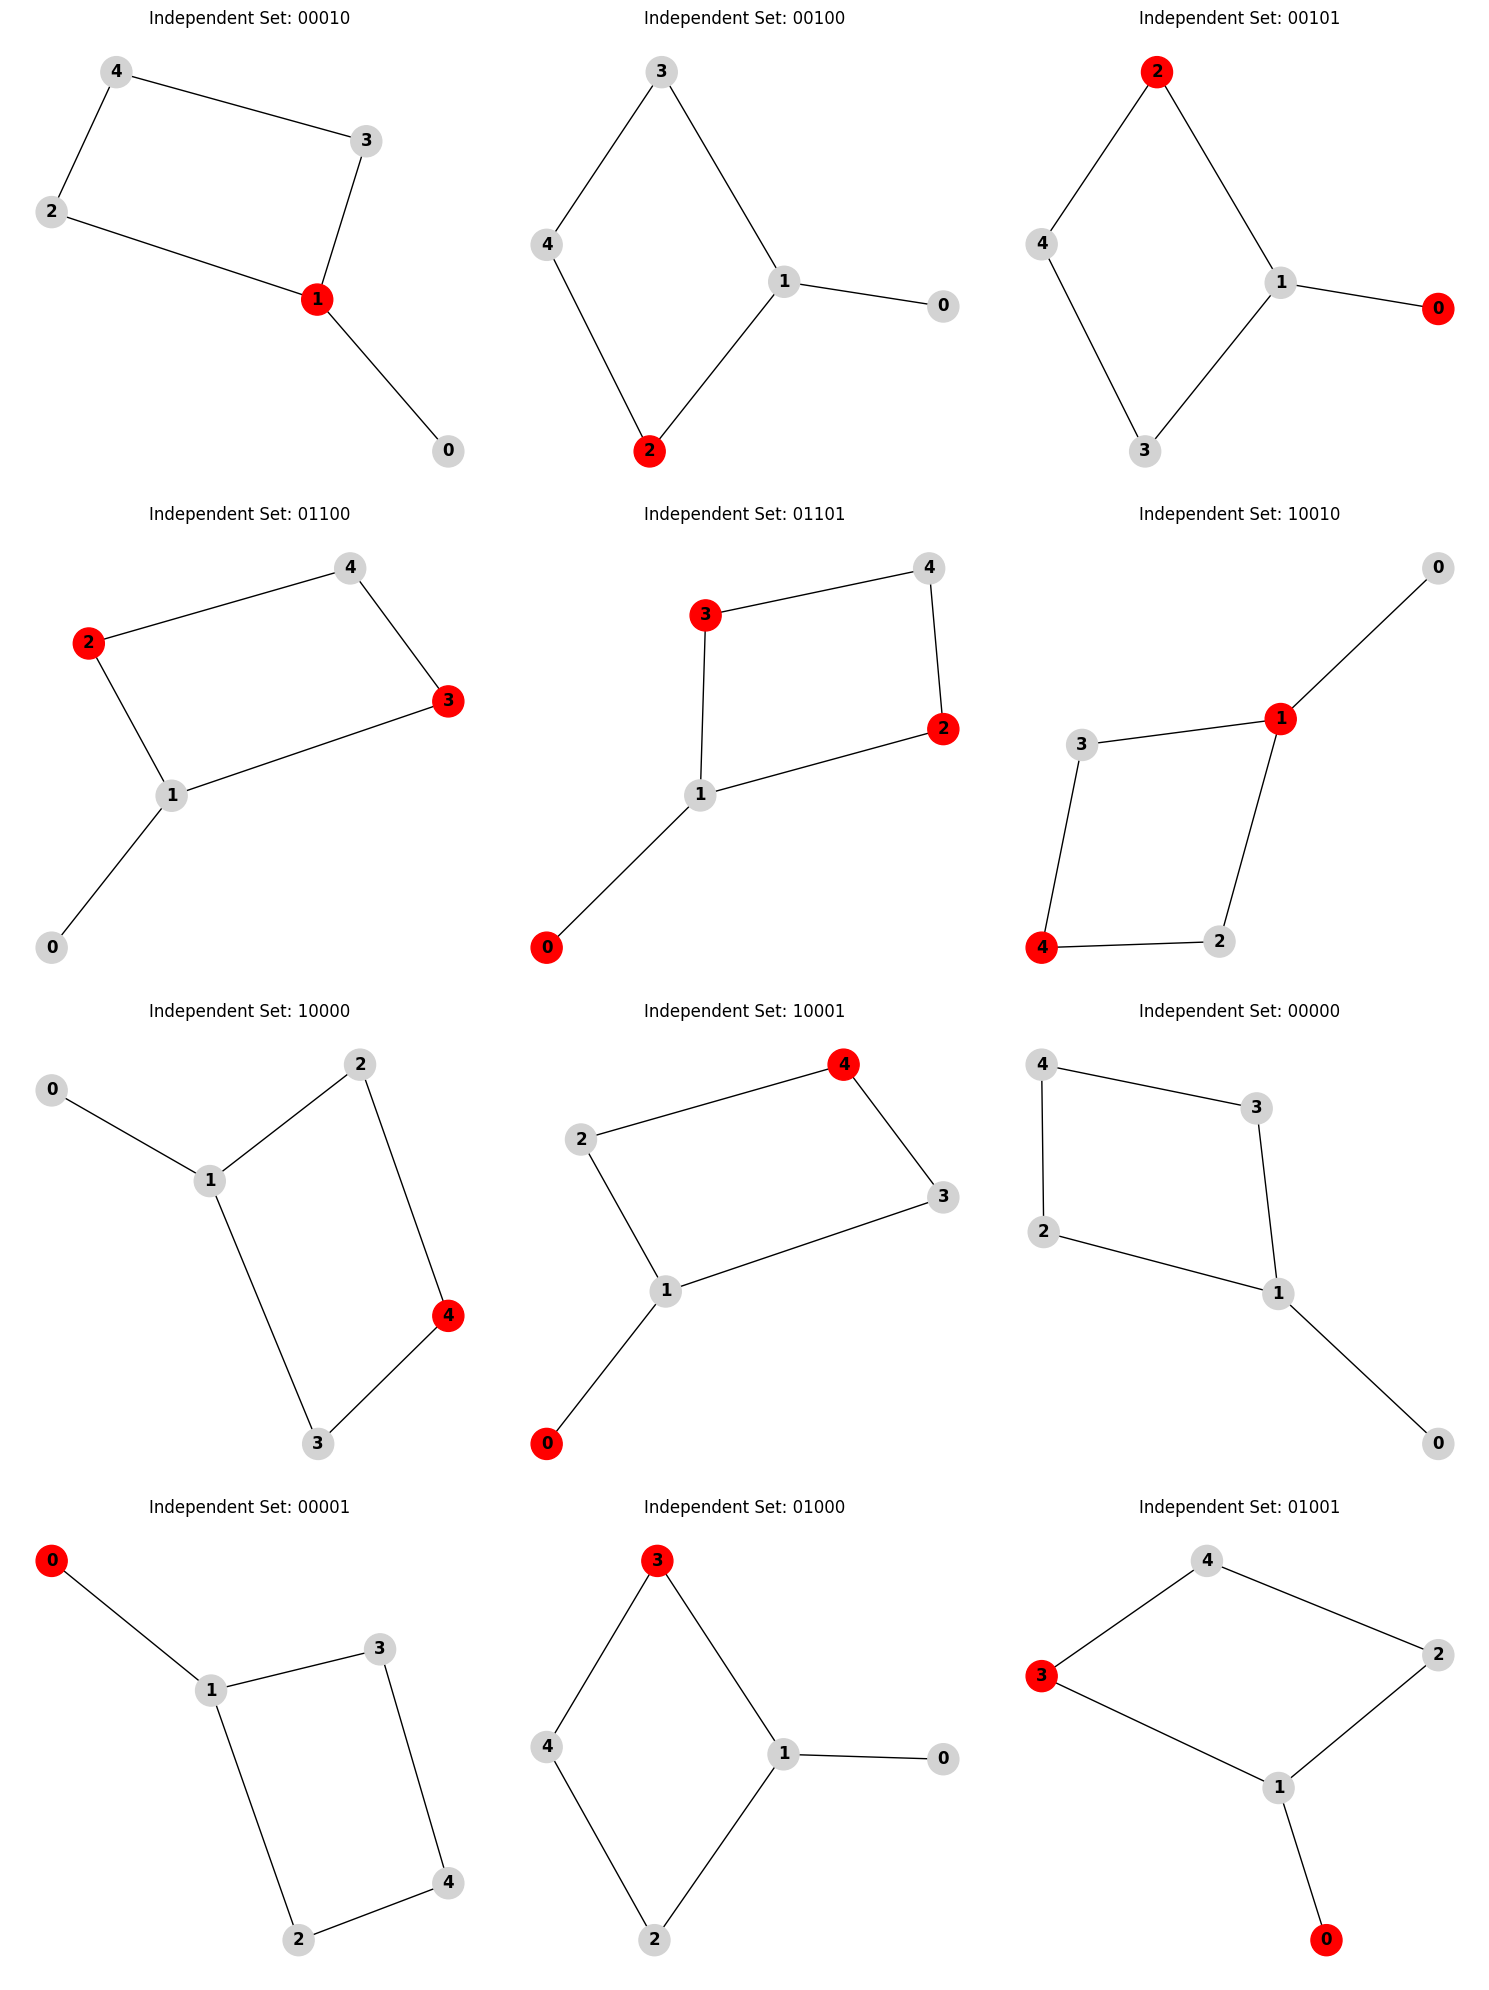

/Users/mac/workspace/quantum-journey/QUANTUM-CLASSICAL-TRANSLATION/venv/lib/python3.9/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


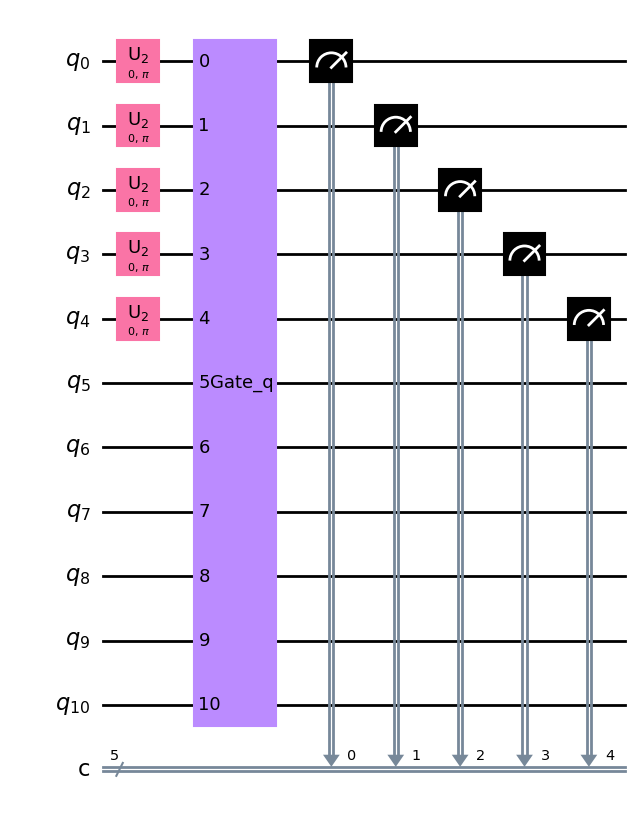

In [7]:
generator = QASMGenerator()
QCs, _ = generator.qasm_generate(classical_code)
Recommender.run(QCs)
circuit = qasm2.loads(QCs.get("grover"), custom_instructions=qasm2.LEGACY_CUSTOM_INSTRUCTIONS)
display(circuit.decompose().draw('mpl'))